# Phân loại email SPAM bằng K-means

**Mục tiêu:** Dùng K-means (unsupervised) để phân nhóm email, sau đó gán nhãn cho các cụm (spam / not-spam).

**Yêu cầu chính:**
- Trích chọn đặc trưng không dùng thư viện (tự cài TF-IDF)
- K-means tự triển khai
- PCA tự triển khai để giảm chiều và phân tích hiệu ứng
- Hiển thị dữ liệu và các kết quả đánh giá


In [44]:
# Cell 1: Imports & load
import re
import numpy as np
import pandas as pd
from collections import Counter

# Đường dẫn tới file CSV trên Colab (chỉnh PATH nếu cần)
PATH = r"C:\Users\thaih\PycharmProjects\BBao_cao_Hoc_may\data\emails.csv"
df = pd.read_csv(PATH)

# Tự động chọn cột text (kiểu object) và cột label (có 'spam' hoặc 'label' trong tên)
text_col, label_col = None, None
for c in df.columns:
    if df[c].dtype == object and text_col is None:
        text_col = c
    if "spam" in c.lower() or "label" in c.lower():
        label_col = c

texts = df[text_col].fillna("").astype(str).tolist()

y = df[label_col].astype(str).str.lower().map(
    lambda x: 1 if x in ("1","spam","true","yes") else 0
).values

print("Các cột trong dataset:", df.columns.tolist())
print("\nCột được chọn làm TEXT:", text_col)
print("Cột được chọn làm LABEL:", label_col)

print("\n5 dòng đầu của hai cột này:")
print(df[[text_col, label_col]].head(10))

print("\nSố lượng label sau khi map:")
print(pd.Series(y).value_counts())


Các cột trong dataset: ['label', 'text']

Cột được chọn làm TEXT: text
Cột được chọn làm LABEL: label

5 dòng đầu của hai cột này:
                                                text  label
0  Subject: naturally irresistible your corporate...      1
1  Subject: the stock trading gunslinger  fanny i...      1
2  Subject: unbelievable new homes made easy  im ...      1
3  Subject: 4 color printing special  request add...      1
4  Subject: do not have money , get software cds ...      1
5  Subject: great nnews  hello , welcome to medzo...      1
6  Subject: here ' s a hot play in motion  homela...      1
7  Subject: save your money buy getting this thin...      1
8  Subject: undeliverable : home based business f...      1
9  Subject: save your money buy getting this thin...      1

Số lượng label sau khi map:
0    4360
1    1368
Name: count, dtype: int64


In [45]:
# Cell 2: Stopwords + tokenize
STOPWORDS = set("""
a an the on in is am are be to from into for with about at
this that these those and or of by as it you me we they
""".split())

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    tokens = [t for t in text.split() if t not in STOPWORDS]

    out = []
    for t in tokens:
        for suf in ("ing","ed","s","ly"):
            if t.endswith(suf) and len(t) > 4:
                t = t[:-len(suf)]
                break
        out.append(t)
    return out

# In thử vài email đầu
for i in range(min(5, len(texts))):
    print("=== Email", i, "===")
    print(texts[i])
    print("Tokens:", tokenize(texts[i]))
    print("------")


=== Email 0 ===
Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordabi

In [46]:
# Cell 3: Build vocab + TF-IDF (không dùng sklearn)
VOCAB_SIZE = 200

counter = Counter()
for text in texts:
    counter.update(set(tokenize(text)))

vocab = [w for w,_ in counter.most_common(VOCAB_SIZE)]
v2i = {w:i for i,w in enumerate(vocab)}

N = len(texts)
X = np.zeros((N, VOCAB_SIZE), dtype=float)
df_counts = np.zeros(VOCAB_SIZE, dtype=float)

for i, text in enumerate(texts):
    tokens = tokenize(text)
    c = Counter(tokens)
    for w, n in c.items():
        if w in v2i:
            j = v2i[w]
            X[i,j] = n
    df_counts += (X[i] > 0).astype(int)

# idf smoothing giống công thức thường dùng
idf = np.log((1 + N) / (1 + df_counts)) + 1

# TF normalization theo row-sum rồi nhân IDF
row_sum = X.sum(axis=1)
row_sum[row_sum == 0] = 1
X = (X.T / row_sum).T * idf

# Kiểm tra một email
idx = 0
tokens = tokenize(texts[idx])
print("Tokens:", tokens)

from collections import Counter as _C
c = _C(tokens)
print("\nTF raw:", c)

vec = X[idx]
print("\nTF-IDF vector (len={}):".format(len(vec)))
print(vec)

top_idx = vec.argsort()[-10:][::-1]
print("\nTop 10 TF-IDF words:")
for j in top_idx:
    print(vocab[j], ":", vec[j])


Tokens: ['subject', 'natural', 'irresistible', 'your', 'corporate', 'identity', 'lt', 'real', 'hard', 'recollect', 'company', 'market', 'full', 'suqgestion', 'information', 'isoverwhelminq', 'but', 'good', 'catchy', 'logo', 'stylish', 'statlonery', 'outstand', 'website', 'will', 'make', 'task', 'much', 'easier', 'do', 'not', 'promise', 'havinq', 'order', 'iogo', 'your', 'company', 'will', 'automaticai', 'become', 'world', 'ieader', 'isguite', 'ciear', 'without', 'good', 'product', 'effective', 'busines', 'organization', 'practicable', 'aim', 'will', 'hotat', 'nowaday', 'market', 'but', 'do', 'promise', 'your', 'market', 'effort', 'will', 'become', 'much', 'more', 'effective', 'here', 'list', 'clear', 'benefit', 'creativenes', 'hand', 'made', 'original', 'logo', 'special', 'done', 'reflect', 'your', 'distinctive', 'company', 'image', 'convenience', 'logo', 'stationery', 'provid', 'all', 'format', 'easy', 'use', 'content', 'management', 'system', 'letsyou', 'change', 'your', 'website', '

In [40]:
# Huấn luyện KMeans

def custom_kmeans(X, K=2, max_iter=300, random_state=None):
    """Thuật toán KMeans tự thân."""
    if random_state is not None:
        np.random.seed(random_state)

    N, D = X.shape
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    centers = min_vals + np.random.rand(K, D) * (max_vals - min_vals)

    labels = np.zeros(N)

    for _ in range(max_iter):
        old_centers = centers.copy()

        # Tính khoảng cách đến centroid & Gán nhãn cho mỗi điểm (Phân cụm)
        dists = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)
        labels = dists.argmin(axis=1)

        # Cập nhật centers
        new_centers = np.zeros_like(centers)
        for k in range(K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers[k, :] = cluster_points.mean(axis=0)
            else:
                new_centers[k, :] = centers[k, :]

        centers = new_centers

        # Hội tụ?
        if np.allclose(old_centers, centers):
            break

    return labels, centers

def map_clusters_to_labels(cluster_labels, y_true):
    """Ánh xạ cluster id -> label (0/1) dựa trên majority trong tập train."""
    mapping = {}
    for c in np.unique(cluster_labels):
        ys = y_true[cluster_labels == c]
        mapping[c] = int(round(ys.mean())) if len(ys) > 0 else 0
    return mapping

def predict_kmeans_labels(X, centers, cluster_to_label):
    """Dự đoán label cho X bằng centers và map đã học."""
    dists = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)
    cluster_pred = dists.argmin(axis=1)
    y_pred = np.array([cluster_to_label.get(c, 0) for c in cluster_pred])
    return y_pred, cluster_pred

# --- Thực hiện Luồng Chính ---

# 1. Chia tập train & test (trên dữ liệu đã PCA)
X_tr, X_te, y_tr, y_te = custom_train_test_split(
    X_for_train, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print(f"Train size: {len(X_tr)}, Test size: {len(X_te)}")

# 2. Huấn luyện KMeans
km_labels_tr, centers= custom_kmeans(X_tr, K=2, random_state=RANDOM_STATE)
km_map = map_clusters_to_labels(km_labels_tr, y_tr)
print("\nKMeans đã huấn luyện trên dữ liệu đã PCA.")
print("Cluster -> label mapping:", km_map)

Train size: 6144, Test size: 1534

KMeans đã huấn luyện trên dữ liệu đã PCA.
Cluster -> label mapping: {np.int64(0): 1, np.int64(1): 0}


In [41]:
# Cell 4: Các Mô hình Supervised Tự thân

# --- Logistic Regression ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def custom_logistic_regression(X, y, learning_rate=0.1, n_iters=5000):
    N, D = X.shape
    W = np.zeros(D)
    b = 0
    for _ in range(n_iters):
        y_predicted = sigmoid(X @ W + b)
        dW = (1 / N) * (X.T @ (y_predicted - y))
        db = (1 / N) * np.sum(y_predicted - y)
        W -= learning_rate * dW
        b -= learning_rate * db

    def predict(X_pred):
        return (sigmoid(X_pred @ W + b) >= 0.5).astype(int)
    return predict

# --- Gaussian Naive Bayes ---
class CustomGaussianNB:
    def __init__(self):
        self.mean = {}
        self.var = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-9
            self.priors[c] = len(X_c) / len(X)

    def _gaussian_density(self, X, mean, var):
        numerator = np.exp(-(X - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return np.sum(np.log(numerator / denominator), axis=1)

    def predict(self, X):
        posteriors = []
        for c in self.classes:
            log_prior = np.log(self.priors[c])
            log_likelihood = self._gaussian_density(X, self.mean[c], self.var[c])
            posteriors.append(log_prior + log_likelihood)

        posteriors = np.array(posteriors).T
        return self.classes[np.argmax(posteriors, axis=1)]

# --- Linear SVM (Simple Optimization) ---
def custom_linear_svc(X, y, learning_rate=0.001, n_iters=10000, C=1.0):
    N, D = X.shape
    W = np.zeros(D)
    b = 0
    y_svm = np.where(y == 0, -1, 1)

    for _ in range(n_iters):
        i = np.random.randint(N)
        xi, yi = X[i, :], y_svm[i]
        margin = yi * (np.dot(xi, W) + b)

        if margin < 1:
            W -= learning_rate * (W - C * yi * xi)
            b -= learning_rate * (- C * yi)
        else:
            W -= learning_rate * (W)

    def predict(X_pred):
        return np.where(X_pred @ W + b >= 0, 1, 0)

    return predict


--- KMeans (PCA=50 dims) - Luồng Chính ---
Accuracy: 1.0000
             precision    recall  f1-score   support

         1: 1.0000  1.0000  1.0000    725
  accuracy:                        1.0000    1534



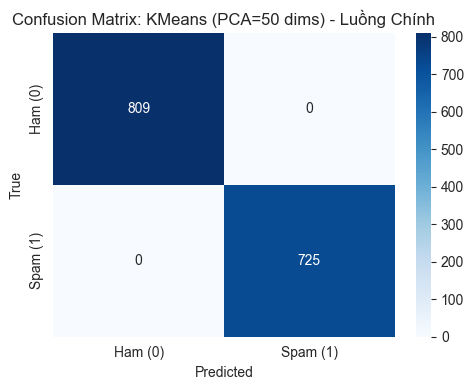


🔥 Bắt đầu so sánh các mô hình (Tất cả trên dữ liệu đã PCA)...

--- KMeans (PCA=50 dims) ---
Accuracy: 1.0000
             precision    recall  f1-score   support

         1: 1.0000  1.0000  1.0000    725
  accuracy:                        1.0000    1534



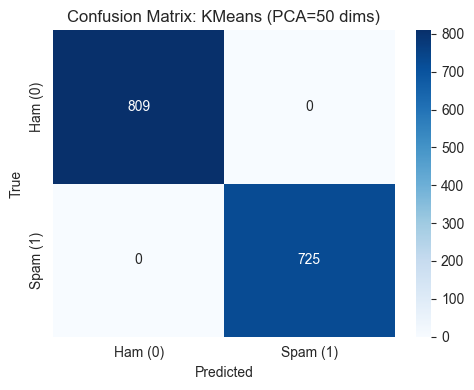


--- Logistic Regression (PCA) ---
Accuracy: 1.0000
             precision    recall  f1-score   support

         1: 1.0000  1.0000  1.0000    725
  accuracy:                        1.0000    1534



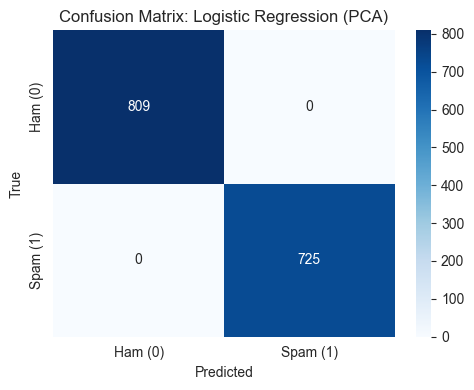


--- Gaussian NB (PCA) ---
Accuracy: 1.0000
             precision    recall  f1-score   support

         1: 1.0000  1.0000  1.0000    725
  accuracy:                        1.0000    1534



C:\Users\thaih\AppData\Local\Temp\ipykernel_15644\4264005150.py:40: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(numerator / denominator), axis=1)


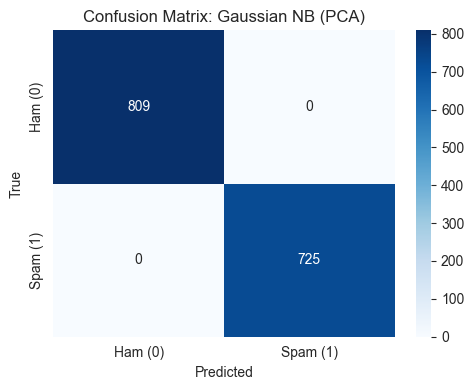


--- Linear SVM (PCA) ---
Accuracy: 1.0000
             precision    recall  f1-score   support

         1: 1.0000  1.0000  1.0000    725
  accuracy:                        1.0000    1534



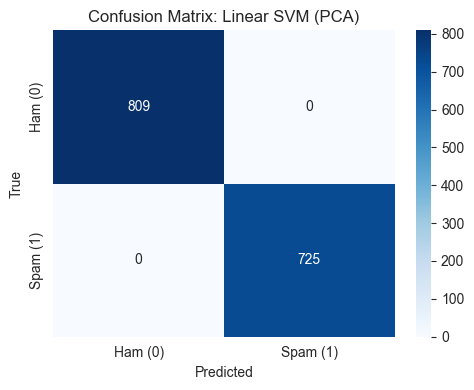

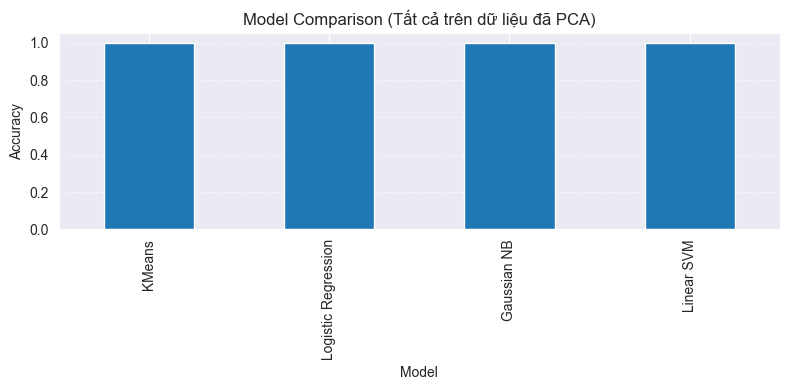


--- Bảng so sánh Accuracy ---
                     Accuracy
Model                        
KMeans                    1.0
Logistic Regression       1.0
Gaussian NB               1.0
Linear SVM                1.0


In [42]:
# Cell 5: Đánh giá và So sánh Mô hình

# --- Hàm Đánh giá Tự thân ---

def custom_accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def custom_confusion_matrix(y_true, y_pred):
    K = 2
    cm = np.zeros((K, K), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def custom_classification_report(y_true, y_pred):
    cm = custom_confusion_matrix(y_true, y_pred)
    TP, FP = cm[1, 1], cm[0, 1]
    TN, FN = cm[0, 0], cm[1, 0]

    precision_1 = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_1 = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    report_str = f"             precision    recall  f1-score   support\n\n"
    report_str += f"         1: {precision_1:.4f}  {recall_1:.4f}  {f1_1:.4f}    {np.sum(y_true)}\n"
    report_str += f"  accuracy:                        {custom_accuracy_score(y_true, y_pred):.4f}    {len(y_true)}\n"

    return report_str

def evaluate_preds(y_true, y_pred, title="Model"):
    """In báo cáo đánh giá và vẽ Confusion Matrix."""
    acc = custom_accuracy_score(y_true, y_pred)
    print(f"\n--- {title} ---")
    print(f"Accuracy: {acc:.4f}")
    print(custom_classification_report(y_true, y_pred))

    cm = custom_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Ham (0)','Spam (1)'],
                yticklabels=['Ham (0)','Spam (1)'])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    return acc, cm

def compare_models(X_train, X_test, y_train, y_test, centers_km, km_map):
    results = []

    # 1. KMeans (Đã PCA)
    y_pred_km, _ = predict_kmeans_labels(X_test, centers_km, km_map)
    acc_km, _ = evaluate_preds(y_test, y_pred_km, title=f"KMeans (PCA={X_train.shape[1]} dims)")
    results.append(("KMeans", acc_km))

    # 2. Logistic Regression (Đã PCA)
    predict_log = custom_logistic_regression(X_train, y_train)
    y_pred_log = predict_log(X_test)
    acc_log, _ = evaluate_preds(y_test, y_pred_log, title="Logistic Regression (PCA)")
    results.append(("Logistic Regression", acc_log))

    # 3. Gaussian NB (Đã PCA)
    clf_nb = CustomGaussianNB()
    clf_nb.fit(X_train, y_train)
    y_pred_nb = clf_nb.predict(X_test)
    acc_nb, _ = evaluate_preds(y_test, y_pred_nb, title="Gaussian NB (PCA)")
    results.append(("Gaussian NB", acc_nb))

    # 4. Linear SVM (Đã PCA)
    predict_svm = custom_linear_svc(X_train, y_train)
    y_pred_svm = predict_svm(X_test)
    acc_svm, _ = evaluate_preds(y_test, y_pred_svm, title="Linear SVM (PCA)")
    results.append(("Linear SVM", acc_svm))

    df_res = pd.DataFrame(results, columns=["Model", "Accuracy"]).set_index("Model")
    df_res.plot.bar(figsize=(8,4), ylim=(0,1.05), legend=False)
    plt.title("Model Comparison (Tất cả trên dữ liệu đã PCA)")
    plt.ylabel("Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return df_res


# --- Thực hiện Đánh giá & So sánh ---

# Đánh giá kết quả của KMeans (luồng chính)
y_pred_km_pca = predict_kmeans_labels(X_te, centers, km_map)[0]
acc_km = evaluate_preds(y_te, y_pred_km_pca, title=f"KMeans (PCA={X_tr.shape[1]} dims) - Luồng Chính")

# So sánh tất cả mô hình
print("\n🔥 Bắt đầu so sánh các mô hình (Tất cả trên dữ liệu đã PCA)...")
df_comparison = compare_models(X_tr, X_te, y_tr, y_te, centers_km=centers, km_map=km_map)
print("\n--- Bảng so sánh Accuracy ---")
print(df_comparison)